<a href="https://colab.research.google.com/github/dhkim0821/Cheetah-Vision-Realsense/blob/master/hw9_soln.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **HW9. Operational Space Control**

The goal of HW 9 is to implement operational space controller on a 3 DoF openchain system described in the figure below, and investigate the tracking performance of the controller. 

<img src="https://github.com/DARoSLab/CS403-Intro-Robotics/blob/main/hws/hw8/3DoF_Arm.png?raw=true" width="450">

In [1]:
!pip3 install sympy matplotlib seaborn ffmpeg-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import sympy as sym
from sympy import Symbol, simplify, lambdify
from sympy.matrices.expressions import transpose
from sympy import sin, cos, Matrix
import numpy as np
from IPython.display import HTML
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import animation
%matplotlib inline


# **Declare Symbolic Variables**

In [3]:
# Symbolic variable definition: No need to change
[m1, m2, m3, I1, I2, I3, l1, l2, l3,  c1, c2, c3, g] = sym.symbols('m1 m2 m3 I1 I2 I3 l1 l2 l3 c1 c2 c3 g')
[th1, th2, th3, dth1, dth2, dth3, ddth1, ddth2, ddth3] = sym.symbols('th1 th2 th3 dth1 dth2 dth3 ddth1 ddth2 ddth3')
[tau1, tau2, tau3] = sym.symbols('tau1 tau2 tau3')

# Symbolic variable groupings
q  = Matrix([th1,  th2, th3])
dq = Matrix([dth1,  dth2, dth3])
ddq= Matrix([ddth1, ddth2, ddth3])
u  = Matrix([tau1, tau2, tau3]) # control input
z = Matrix([q.transpose(), dq.transpose()]) # state
p   = [l1, l2, l3, c1, c2, c3, m1, m2, m3, I1, I2, I3, g]  # parameters

In [4]:
# Handy functions to be used to compute time derivative and generalized forces: No need to change
ddt = lambda x: x.jacobian(q)*dq + x.jacobian(dq)*ddq
F2Q = lambda F, r : simplify(r.jacobian(q).transpose()*F)   # force contributions to generalized forces
M2Q = lambda M, w : simplify(w.jacobian(dq).transpose()*M)   # moment contributions to generalized forces

# Q.1. [20 pts] **Kinemeatics**

Complete the code to compute the positions and velocities of the points of interest. Here all positions and velocities (angular and linear) should be defined to compute kinetic and potential energies.

In [5]:
# Kinemeatics
rO = Matrix([0, 0, 0])    # position of link 1
ehat1 = Matrix([cos(th1), sin(th1), 0])           # Define unit vector along Leg 1
ehat2 = Matrix([cos(th1+th2), sin(th1+th2), 0])  # Define unit vector along Leg 2
ehat3 = Matrix([cos(th1+th2+th3), sin(th1+th2+th3), 0])  # Define unit vector along Leg 2

ghat  = Matrix([0, -1 , 0])                       

# Write your code: Define CoM position and link position
rB  = l1*ehat1          # Position of base of link 1
rC  = rB + l2*ehat2     # Position of end of link 2
rD  = rC + l3*ehat3     # Position of end of link 3

rc1 = c1*ehat1          # Position of link 1 CoM
rc2 = rB + c2*ehat2     # Position of CoM of link 2
rc3 = rC + c3*ehat3     # Position of CoM of link 3


# Write your code: Define linear and angular velocity of each link
# Hint: Utilize 'ddt' function

vc1 = ddt(rc1)          # Velocity of link 1 CoM
vc2 = ddt(rc2)          # Velocity of link 2 CoM
vc3 = ddt(rc3)          # Velocity of link 3 CoM

# Q.2. [15 pts] **Kinetic and Potential Energy of Links**

Define the kinetic and potential energy of each link

In [6]:
# Write your code: Kinetic and Potential Energy of link 1
T1 = simplify( 1/2 * m1 * vc1.dot(vc1) + 1/2 * I1 * dth1*dth1 )
V1 = m1 * g * (rc1.dot(-ghat))

# Write your code: Kinetic and Potential Energy of link 2
T2 = simplify( 1/2 * m2 * vc2.dot(vc2) + 1/2 * I2 * (dth1+dth2)*(dth1+dth2))
V2 = m2 * g * rc2.dot(-ghat)

# Write your code: Kinetic and Potential Energy of link 3
T3 = simplify( 1/2 * m3 * vc3.dot(vc3) + 1/2 * I3 * (dth1+dth2+dth3)*(dth1+dth2+dth3))
V3 = m3 * g * rc3.dot(-ghat)


# Q.3. [10 pts] **Lagrangian and Total Energy (Hamiltonian)**

In [7]:
# Write your code: Kinetic, Potential, and total energy of the entire system
KE = T1 + T2 + T3
PE = V1 + V2 + V3
E = Matrix([simplify(KE + PE)])

# Write your code: Lagrangian
L = Matrix([simplify(KE - PE)])

# Q.3. **Generalized Forces**

Define generalized force vectors using a M2Q function. 

Hint: The result should be $Q = \begin{pmatrix}\tau_1 \\ \tau_2 \\ \tau_3\end{pmatrix}$. 

In [8]:
Q_tau1 = M2Q(tau1,Matrix([dth1]))
Q_tau2 = M2Q(tau2,Matrix([dth2+dth1])) + M2Q(-tau2, Matrix([dth1]))
Q_tau3 = M2Q(tau3,Matrix([dth3+dth2+dth1])) + M2Q(-tau3, Matrix([dth1+dth2]))

Q = Q_tau1 + Q_tau2 + Q_tau3

print(Q_tau1)
print(Q_tau2)
print(Q_tau3)

print(Q)

Matrix([[tau1], [0], [0]])
Matrix([[0], [tau2], [0]])
Matrix([[0], [0], [tau3]])
Matrix([[tau1], [tau2], [tau3]])


# **Equations of Motion**

Complete the equations of motion by applying Lagrange formula. Find A (Mass matrix) and b vector explained in the lecture.

In [9]:
dL_dq = L.jacobian(q).transpose()
dL_dqd= L.jacobian(dq).transpose()

eom = ddt(dL_dqd) - dL_dq - Q
A = simplify(eom.jacobian(ddq))
b = simplify( A*ddq - eom)

grav = simplify(Matrix([PE]).jacobian(q))
simplify(A)

Matrix([
[1.0*I1 + 1.0*I2 + 1.0*I3 + 1.0*c1**2*m1 + m2*(c2**2 + 2*c2*l1*cos(th2) + l1**2) + m3*(c3**2 + 2*c3*l1*cos(th2 + th3) + 2*c3*l2*cos(th3) + l1**2 + 2*l1*l2*cos(th2) + l2**2), 1.0*I2 + 1.0*I3 + c2*m2*(c2 + l1*cos(th2)) + m3*(c3**2 + c3*l1*cos(th2 + th3) + 2*c3*l2*cos(th3) + l1*l2*cos(th2) + l2**2), 1.0*I3 + c3*m3*(c3 + l1*cos(th2 + th3) + l2*cos(th3))],
[                                                 1.0*I2 + 1.0*I3 + c2*m2*(c2 + l1*cos(th2)) + m3*(c3**2 + c3*l1*cos(th2 + th3) + 2*c3*l2*cos(th3) + l1*l2*cos(th2) + l2**2),                                                     1.0*I2 + 1.0*I3 + 1.0*c2**2*m2 + m3*(c3**2 + 2*c3*l2*cos(th3) + l2**2),                     1.0*I3 + c3*m3*(c3 + l2*cos(th3))],
[                                                                                                                      1.0*I3 + c3*m3*(c3 + l1*cos(th2 + th3) + l2*cos(th3)),                                                                                          1.0*I3 + c3*m3*(c3 +

In [10]:
keypoints = Matrix([[rO],[rB],[rC], [rD]]).reshape(4, 3)

# Find the end-effector Jacobian

In [11]:
rD_full = Matrix([rD, th1+th2+th3])
J = rD_full.jacobian(q)[[0, 1, 3], : ] # removing z from the jacobian
Jdot = ddt(J.reshape(9,1)).reshape(3, 3)
vD = Jdot*dq 
print(J)

Matrix([[-l1*sin(th1) - l2*sin(th1 + th2) - l3*sin(th1 + th2 + th3), -l2*sin(th1 + th2) - l3*sin(th1 + th2 + th3), -l3*sin(th1 + th2 + th3)], [l1*cos(th1) + l2*cos(th1 + th2) + l3*cos(th1 + th2 + th3), l2*cos(th1 + th2) + l3*cos(th1 + th2 + th3), l3*cos(th1 + th2 + th3)], [1, 1, 1]])


# **Helper Functions For Simulation**

In [12]:
zp_params = list(z)+list(p)
zup_params = list(z)+list(u)+list(p)
A_func = sym.lambdify(zp_params, A)
b_func = sym.lambdify(zup_params, b)
keypoints_func = sym.lambdify(zp_params, keypoints)
kinetic_energy_func = sym.lambdify(zp_params, KE)
potential_energy_func = sym.lambdify(zp_params, PE)
E_func = sym.lambdify(zp_params, E)
J_func = sym.lambdify(zp_params, J)
Jdot_func = sym.lambdify(zp_params, Jdot)
ee_func = sym.lambdify(zp_params, rD_full)
grav_func = sym.lambdify(zp_params, grav)
vD_func = sym.lambdify(zp_params, vD)

# **SIMULATION**

In [13]:
def dynamics(x, params, control_func=None):
  xp_params = list(x) + list(params)
  u = control_func(x, params)
  xup_params = list(x) + u + list(params)

  A_dyn = A_func(*xp_params)
  b_dyn = b_func(*xup_params)
  qdd = np.matmul(np.linalg.pinv(A_dyn), b_dyn)
  
  dx = 0*x
  dx[:3] = x[3:]
  dx[3:] = qdd.reshape(3)

  return dx

In [34]:
def kin_controller(x, params, xee_des, K, D):
  xp_params = list(x) + list(params)
  J_ee = J_func(*xp_params)
  pee  = ee_func(*xp_params)[[0, 1, 3]]
  vee  = J_ee @ np.array(x[3:])
  xee = np.zeros(6)
  xee[:3] = pee.reshape(-1)
  xee[3:] = vee
  e = xee_des[:3] - xee[:3]
  ed = xee_des[3:6] - xee[3:]
  return (J_ee.T@(K*e + D*ed)).tolist()

def controller_grav_comp(x, params, xee_des, K, D):
  xp_params = list(x) + list(params)
  J_ee = J_func(*xp_params)
  pee  = ee_func(*xp_params)[[0, 1, 3]]
  tau_g = grav_func(*xp_params)[0]
  vee  = J_ee @ np.array(x[3:])
  xee = np.zeros(6)
  xee[:3] = pee.reshape(-1)
  xee[3:] = vee
  e = xee_des[:3] - xee[:3]
  ed = xee_des[3:6] - xee[3:]
  return (J_ee.T@(K*e + D*ed) + tau_g).tolist()

def controller_OSC(x, params, xee_des, K, D):
  xp_params = list(x) + list(params)
  J = J_func(*xp_params)
  pee  = ee_func(*xp_params)[[0, 1, 3]].reshape(-1)
  vee  = J @ np.array(x[3:])
  
  e = xee_des[:3] - pee
  ed = xee_des[3:6] - vee
  # print(e, ed)
  
  # command  = (xee_des[6:] + K*e + D*ed).reshape(3,1)
  command  = (K*e + D*ed).reshape(3,1)
  # print(f"command = {command}")
  M = A_func(*xp_params)
  x_vel_zero = x.copy()
  x_vel_zero[3:] = 0
  u_zero = [0, 0, 0]
  xup_gzero_params = list(x_vel_zero) + u_zero + list(params)
  xup_czero_params = list(x) + u_zero + list(params)

  grav = (-b_func(*xup_gzero_params)).reshape(-1,1)
  # print(f"grav: {grav}")

  coriolis = (-b_func(*xup_czero_params)).reshape(-1,1) - grav;
  # print(f"cor: {coriolis}")
  
  Jdot = Jdot_func(*xp_params);
  # print(f"Jdot = {Jdot}")

  M_inv = np.linalg.inv(M)
  Lambda_inv = J@M_inv@J.T
  # print(f"Lamdainv = {Lambda_inv}")

  Lambda = np.linalg.inv(Lambda_inv)
  # print(f"Lamda = {Lambda}")
  # print(f"Lambda@J@np.linalg.inv(M)@coriolis =  {Lambda@J@np.linalg.inv(M)@coriolis}")
  
  qdot = x[3:].reshape(3, 1)
  # print(f"qdot : {qdot}")
  # print(f"Lambda@Jdot@x[3:].T = {Lambda@Jdot@qdot }")
  mu = Lambda@J@M_inv@coriolis #- Lambda@Jdot@qdot 
  # print(f"mu = {mu}")

  rho = Lambda@J@M_inv@grav;
  # print(f"rho = {rho}")
  
  F = Lambda@command + mu + rho;
  # F = Lambda@command;
  # F = command;

  # F = Lambda@command + rho;
  # F = Lambda@command + mu; 
  # F = command;
  # print(f"F: {F}")

  u = (J.T@F).reshape(-1).tolist()
  # u = (J.T@F).tolist()
  # print(f"u = {u}")
  return u


# **Perform Simulation**

In [35]:
m1_p = 1.5
m2_p = 1.
m3_p = 2.0
l1_p = .6
l2_p = .4
l3_p = .5
c1_p = .3
c2_p = .2
c3_p = .4
I1_p = 0.05
I2_p = 0.05
I3_p = 0.09

g_p  = 9.81    
params   = [l1_p, l2_p , l3_p, c1_p, c2_p, c3_p, m1_p, m2_p, m3_p, I1_p, I2_p, I3_p, g_p]
dt = 0.002;
tf = 3.0;
num_step = int(np.floor(tf/dt));
tspan = np.linspace(0, tf, num_step); 
x0 = np.array([1, -1, 1, 0.0, 0.0, 0.0]).T; 
x_out = np.zeros((6,num_step));
x_out[:,0] = x0;
keypoints_hist = []
kinetic_energy_hist = []
potential_energy_hist = []
total_energy_hist = []

r0 = 0.8
r_circle = 0.2
omega = 2*np.pi*0.5


xee_des = np.zeros((num_step, 9))
xee_des[:, :] = np.array([0.8, 0.9, 3.0, 0, 0, 0, 0, 0, 0]) # pos vel and acc
for i in range(num_step):
  t = i*dt
  xee_des[i, :] = np.array([r0 + r_circle*np.cos(omega*t), r0 + r_circle*np.sin(omega*t), np.pi/4, # position
                            -omega*r_circle*np.sin(omega*t), omega*r_circle*np.cos(omega*t), 0, # vel
                            -omega*omega*r_circle*np.cos(omega*t), -omega*omega*r_circle*np.sin(omega*t), 0]) # acc

# xee_des_list = np.repeat(xee_des, [1, num_step], axis=0)
K = 700.0
D = 30

for i in range(num_step-1):
    xp_params = list(x_out[:, i]) + list(params)
    keypoints_hist.append(keypoints_func(*xp_params))
    kinetic_energy_hist.append(kinetic_energy_func(*xp_params))
    potential_energy_hist.append(potential_energy_func(*xp_params))
    total_energy_hist.append(E_func(*xp_params))

    confunc = lambda x, params: controller_OSC(x, params, xee_des[i], K, D)
    # confunc = lambda x, params: kin_controller(x, params, xee_des[i], K, D)

    dx = dynamics(x_out[:,i], params, control_func=confunc)
    x_out[3:,i+1] = x_out[3:,i] + dx[3:]*dt
    x_out[:3,i+1] = x_out[:3,i] + x_out[3:,i+1]*dt
    

# **Visualize Simulation**

In [28]:
from re import X
# 3 dof arm visualization function: 
def visualize_arm(keypoints_hist, xee_des=None, dt = 0.001, num_frames=200):
  fig= plt.figure(figsize=(10,10))
  ax = plt.subplot(1,1,1)
  ax.grid()
  keypoints = keypoints_hist[0]
  link1, = ax.plot([], [], 'r', lw=15, alpha=0.3)
  link2, = ax.plot([], [], 'r', lw=15, alpha=0.3)
  link3, = ax.plot([], [], 'r', lw=15, alpha=0.3)
  if xee_des is not None:
    # arrow_length = 0.5 
    # target, = ax.plot([xee_des[0], xee_des[0] + arrow_length*np.cos(xee_des[2])], 
    #                   [xee_des[1], xee_des[1] + arrow_length*np.sin(xee_des[2])], 
    #                   label='target', lw=4)
    target, = ax.plot(xee_des[:, 0], xee_des[:, 1], 'o', label='target')

  txt_title = ax.set_title('')
  
  ax.set_xlim(( -0.5, 2))            
  ax.set_ylim((-0.5, 2))
  txt_title = ax.set_title('')
  interval = len(keypoints_hist)//num_frames
  def drawFrame(k):
    k = interval*k
    keypts = keypoints_hist[k]

    x1 = keypts[0, 0]
    x2 = keypts[1, 0]
    y1 = keypts[0, 1]
    y2 = keypts[1, 1]
    link1.set_data([x1, x2], [y1, y2])
    x1 = keypts[1, 0]
    x2 = keypts[2, 0]
    y1 = keypts[1, 1]
    y2 = keypts[2, 1]
    link2.set_data([x1, x2], [y1, y2])
    x1 = keypts[2, 0]
    x2 = keypts[3, 0]
    y1 = keypts[2, 1]
    y2 = keypts[3, 1]
    link3.set_data([x1, x2], [y1, y2])
    txt_title.set_text(f't = {dt*k:.2f} sec')
    return link1, link2, link3
  anim = animation.FuncAnimation(fig, drawFrame, frames=num_frames, interval=interval, blit=True)
  return anim

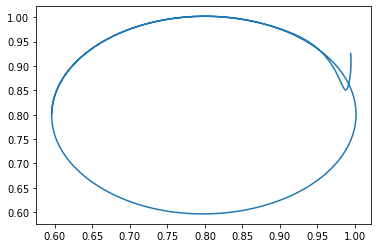

In [36]:
leng = len(keypoints_hist)
ee_x = np.zeros([leng,1])
ee_y = np.zeros([leng, 1]) 
for i in range(leng):
  ee_x[i] = keypoints_hist[i][3,0]
  ee_y[i] = keypoints_hist[i][3,1]

plt.plot(ee_x, ee_y)
plt.show()

In [37]:
anim = visualize_arm(keypoints_hist, xee_des=xee_des, dt = dt, num_frames=200)
plt.close()
HTML(anim.to_html5_video())

# Feed Forward Gravity Compensation

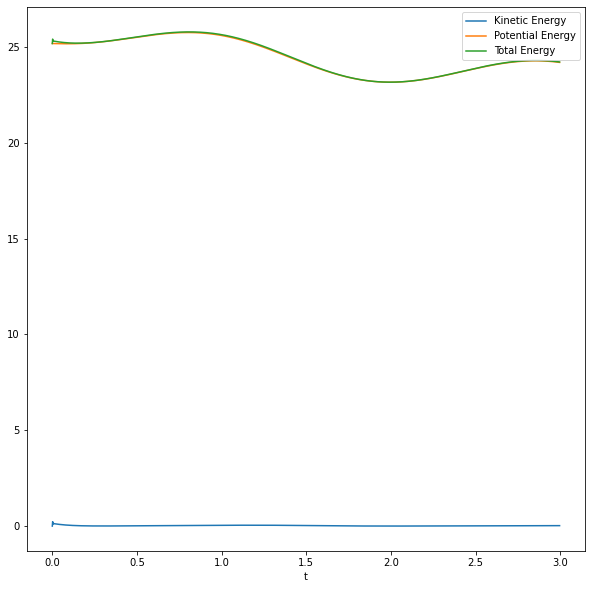

In [19]:
# Plot Kinetic Energy, Potential Energy and Total Energy 
kinetic_energy_hist_np = np.array(kinetic_energy_hist)
potential_energy_hist_np = np.array(potential_energy_hist)
total_energy_hist_np = np.array(total_energy_hist).reshape(-1)
ts = np.arange(0, tf-dt, dt)
fig= plt.figure(figsize=(10,10))
ax = plt.subplot(1,1,1)   
ax.plot(ts, kinetic_energy_hist_np, label='Kinetic Energy')
ax.plot(ts, potential_energy_hist_np, label='Potential Energy')
ax.plot(ts, total_energy_hist_np, label='Total Energy')
ax.legend()
ax.set_xlabel('t')
plt.show()

In [20]:
x_out[:, 0]

array([ 1., -1.,  1.,  0.,  0.,  0.])

# (Optional) [10 pts] Try different gain sets and analyze the results based on what we learned in Lecture 17. Feedback control. 